In [1]:
import super_gradients

The console stream is logged into C:\Users\dpatricio\sg_logs\console.log


[2023-11-07 14:15:35] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-07 14:15:38] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-07 14:15:39,069] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-11-07 14:16:54] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-07 14:16:54] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-07 14:16:54] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-07 14:16:54] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [2]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

In [4]:
model = models.get(Models.YOLOX_N, num_classes=2,pretrained_weights='coco')

Downloading: "https://sghub.deci.ai/models/yolox_n_coco.pth" to C:\Users\dpatricio/.cache\torch\hub\checkpoints\yolox_n_coco.pth
100%|██████████| 11.1M/11.1M [00:01<00:00, 7.00MB/s]
[2023-11-07 14:26:00] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_n


In [5]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from torchvision import transforms, utils
import numpy as np
import glob
import random


class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.lower()

        assert self.split in {'train', 'test'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        # with open(os.path.join(data_folder, self.split + '.txt'), 'r') as j:
        #     self.images = j.readlines()
        self.images = glob.glob(data_folder+"images/"+self.split+"/"+"*.jpg")
        self.images = [i.replace("\\","/") for i in self.images]
        self.images = random.sample(self.images,20)

    def __getitem__(self, i):
        # Read image and label
        image = Image.open(self.images[i].replace("\n","").replace("\\","/"), mode='r').resize((320, 320))
        image = image.convert("RGB")
        # image_tensor = torch.tensor(np.expand_dims(image,axis=-1)).permute(2, 0, 1).float()
        image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).float()
        labels = np.loadtxt(self.images[i].replace("jpg","txt").replace("images", "labels"))
        if len(labels.shape) == 1:
            labels = np.transpose(np.expand_dims(labels,axis=-1))
        return image_tensor, torch.tensor(labels,dtype=torch.float)
        

    def __len__(self):
        return len(self.images)

In [6]:
train_dataset = CustomDataset("dataset_deteccao/axial_t1wce_2_class_corrigida/",split="train")
val_dataset = CustomDataset("dataset_deteccao/axial_t1wce_2_class_corrigida/",split="test")

In [7]:
from torch.utils.data import Dataset, DataLoader
from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=DetectionCollateFN())
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN())

In [43]:
from super_gradients.training import training_hyperparams

from prettyformatter import pprint

train_params = training_hyperparams.get('coco2017_yolox.yaml')
print('Training parameters:')
pprint(train_params, json=True)

Training parameters:
{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 5,
    "lr_warmup_steps"   : 0,
    "lr_cooldown_epochs": 15,
    "warmup_initial_lr" : null,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.05,
    "warmup_mode"       : "LinearEpochLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "SGD",
    "optimizer_params"  : {"momentum": 0.9, "weight_decay": 0.0005, "nesterov": true},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "YoloXDetectionLoss",
    "criterion_params"  : {"strides": [8, 16, 32], "num_classes": 80},
    "ema"       : true,
    "ema_params": {"decay": 0.9999, "decay_type": "exp", "beta": 15},
    "train_metrics_list": [],
    "v

In [44]:
train_params['max_epochs'] = 10
# train_params['lr_warmup_epochs'] = 0
# train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = 2
train_params['valid_metrics_list'][0]['DetectionMetrics']['num_cls'] =2
# train_params['average_best_models'] = False
# train_params['initial_lr'] = 0.01
# train_params['cosine_final_lr_ratio'] = 0.9
# train_params['mixed_precision'] = False
# train_params['phase_callbacks'] = []
# train_params['lr_warmup_steps'] = 10
# train_params['valid_metrics_list'] = [{"DetectionMetrics": {"post_prediction_callback": super_gradients.training.utils.ssd_utils.SSDPostPredictCallback(), "num_cls": 3}}]

In [45]:
pprint(train_params, json=True)

{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 5,
    "lr_warmup_steps"   : 0,
    "lr_cooldown_epochs": 15,
    "warmup_initial_lr" : null,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.05,
    "warmup_mode"       : "LinearEpochLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "SGD",
    "optimizer_params"  : {"momentum": 0.9, "weight_decay": 0.0005, "nesterov": true},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "YoloXDetectionLoss",
    "criterion_params"  : {"strides": [8, 16, 32], "num_classes": 2},
    "ema"       : true,
    "ema_params": {"decay": 0.9999, "decay_type": "exp", "beta": 15},
    "train_metrics_list": [],
    "valid_metrics_list":
  

In [10]:
from super_gradients.training import Trainer, MultiGPUMode

In [11]:
CHECKPOINT_DIR = '.'

In [12]:
super_gradients.setup_device(num_gpus=0)

[2023-11-07 14:26:42] WARNING - distributed_training_utils.py - CUDA device is not available on your device... Moving to CPU.


In [52]:
from super_gradients.training.processing import ImagePermute, ComposeProcessing

image_processor = ComposeProcessing(
    [
        # Resize(320),
        ImagePermute(permutation=(2, 0, 1)),
    ]
)


In [53]:
model.set_dataset_processing_params(iou=0.5,class_names=['negative','positive'],conf=0.5,image_processor=image_processor)

In [54]:
trainer = Trainer(experiment_name='transfer_learning_object_detection_yolo_x_n', ckpt_root_dir=CHECKPOINT_DIR)

In [55]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2023-11-07 16:30:14] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231107_163014_800986`
[2023-11-07 16:30:14] INFO - sg_trainer.py - Checkpoints directory: .\transfer_learning_object_detection_yolo_x_n\RUN_20231107_163014_800986


The console stream is now moved to .\transfer_learning_object_detection_yolo_x_n\RUN_20231107_163014_800986/console_Nov07_16_30_15.txt


[2023-11-07 16:30:16] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}
[2023-11-07 16:30:17] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         OFF
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            20         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         5          (len(train_loader))
    - Gradient updates per epoch:   5          (len(train_loader) / batch_accumulate)

[2023-11-07 16:30:17] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validating: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]
[2023-11-07 16:30:33] INFO - base_sg_logger.py -

SUMMARY OF EPOCH 0
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   ├── Yoloxdetectionloss/obj = 0.0098
│   ├── Yoloxdetectionloss/cls = 0.0012
│   ├── Yoloxdetectionloss/l1 = 0.0
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   └── Yoloxdetectionloss/loss = 5.011
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    ├── Yoloxdetectionloss/obj = 16.7276
    ├── Yoloxdetectionloss/cls = 0.0189
    ├── Yoloxdetectionloss/l1 = 0.0
    ├── Yoloxdetectionloss/num_fg = 0.88
    ├── Yoloxdetectionloss/loss = 21.7465
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0094
│   │   ├── Epoch N-1      = 0.0098 (↘ -0.0004)
│   │   └── Best until now = 0.0098 (↘ -0.0004)
│   ├── Yoloxdetectionloss/cls = 0.0011
│   │   ├── Epoch N-1      = 0.0012 (↘ -0.0)
│   │   └── Best until now = 0.0012 (↘ -0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0106
│       ├── Epoch N-1      = 5.011  (↘ -0.0004)
│       └── Best until now = 5.011  (↘ -0.0004)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.0798
    │   ├─

Validating epoch 2: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0095
│   │   ├── Epoch N-1      = 0.0094 (↗ 0.0)
│   │   └── Best until now = 0.0094 (↗ 0.0)
│   ├── Yoloxdetectionloss/cls = 0.0011
│   │   ├── Epoch N-1      = 0.0011 (↗ 0.0)
│   │   └── Best until now = 0.0011 (↗ 0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0106
│       ├── Epoch N-1      = 5.0106 (↗ 1e-04)
│       └── Best until now = 5.0106 (↗ 1e-04)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.2258
    │   ├── Epoch N-1   

Validating epoch 3: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0091
│   │   ├── Epoch N-1      = 0.0095 (↘ -0.0004)
│   │   └── Best until now = 0.0094 (↘ -0.0003)
│   ├── Yoloxdetectionloss/cls = 0.0011
│   │   ├── Epoch N-1      = 0.0011 (↘ -0.0)
│   │   └── Best until now = 0.0011 (↘ -0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0103
│       ├── Epoch N-1      = 5.0106 (↘ -0.0004)
│       └── Best until now = 5.0106 (↘ -0.0003)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.2763
    │   ├─

Validating epoch 4: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0093
│   │   ├── Epoch N-1      = 0.0091 (↗ 0.0002)
│   │   └── Best until now = 0.0091 (↗ 0.0002)
│   ├── Yoloxdetectionloss/cls = 0.0012
│   │   ├── Epoch N-1      = 0.0011 (↗ 0.0)
│   │   └── Best until now = 0.0011 (↗ 0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0105
│       ├── Epoch N-1      = 5.0103 (↗ 0.0002)
│       └── Best until now = 5.0103 (↗ 0.0002)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.2927
    │   ├── Epoc

Validating epoch 5: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0086
│   │   ├── Epoch N-1      = 0.0093 (↘ -0.0007)
│   │   └── Best until now = 0.0091 (↘ -0.0005)
│   ├── Yoloxdetectionloss/cls = 0.0012
│   │   ├── Epoch N-1      = 0.0012 (↘ -0.0)
│   │   └── Best until now = 0.0011 (↗ 0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0098
│       ├── Epoch N-1      = 5.0105 (↘ -0.0007)
│       └── Best until now = 5.0103 (↘ -0.0005)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.2986
    │   ├──

Validating epoch 6: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0084
│   │   ├── Epoch N-1      = 0.0086 (↘ -0.0002)
│   │   └── Best until now = 0.0086 (↘ -0.0002)
│   ├── Yoloxdetectionloss/cls = 0.0012
│   │   ├── Epoch N-1      = 0.0012 (↗ 0.0)
│   │   └── Best until now = 0.0011 (↗ 0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0096
│       ├── Epoch N-1      = 5.0098 (↘ -1e-04)
│       └── Best until now = 5.0098 (↘ -1e-04)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.3017
    │   ├── Ep

Validating epoch 7: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0078
│   │   ├── Epoch N-1      = 0.0084 (↘ -0.0006)
│   │   └── Best until now = 0.0084 (↘ -0.0006)
│   ├── Yoloxdetectionloss/cls = 0.0011
│   │   ├── Epoch N-1      = 0.0012 (↘ -0.0)
│   │   └── Best until now = 0.0011 (↗ 0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.009
│       ├── Epoch N-1      = 5.0096 (↘ -0.0007)
│       └── Best until now = 5.0096 (↘ -0.0007)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.3043
    │   ├── 

Validating epoch 8: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0075
│   │   ├── Epoch N-1      = 0.0078 (↘ -0.0003)
│   │   └── Best until now = 0.0078 (↘ -0.0003)
│   ├── Yoloxdetectionloss/cls = 0.0012
│   │   ├── Epoch N-1      = 0.0011 (↗ 0.0)
│   │   └── Best until now = 0.0011 (↗ 0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0087
│       ├── Epoch N-1      = 5.009  (↘ -0.0003)
│       └── Best until now = 5.009  (↘ -0.0003)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.3069
    │   ├── 

Validating epoch 9: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Yoloxdetectionloss/iou = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   ├── Yoloxdetectionloss/obj = 0.0072
│   │   ├── Epoch N-1      = 0.0075 (↘ -0.0003)
│   │   └── Best until now = 0.0075 (↘ -0.0003)
│   ├── Yoloxdetectionloss/cls = 0.0012
│   │   ├── Epoch N-1      = 0.0012 (↗ 0.0)
│   │   └── Best until now = 0.0011 (↗ 0.0)
│   ├── Yoloxdetectionloss/l1 = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Yoloxdetectionloss/num_fg = 1.0
│   │   ├── Epoch N-1      = 1.0    (= 0.0)
│   │   └── Best until now = 1.0    (= 0.0)
│   └── Yoloxdetectionloss/loss = 5.0084
│       ├── Epoch N-1      = 5.0087 (↘ -0.0003)
│       └── Best until now = 5.0087 (↘ -0.0003)
└── Validation
    ├── Yoloxdetectionloss/iou = 1.0
    │   ├── Epoch N-1      = 1.0    (= 0.0)
    │   └── Best until now = 1.0    (= 0.0)
    ├── Yoloxdetectionloss/obj = 17.3096
    │   ├── 

[2023-11-07 16:32:18] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

In [62]:
val_dataset.__getitem__(0)[0].shape

torch.Size([3, 320, 320])

In [57]:
image_test_tensor = torch.tensor(np.array(val_dataset.__getitem__(0)[0])).permute(1, 2, 0).float()

Validating epoch 10: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]
[2023-11-07 16:32:20] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [58]:
np.expand_dims(val_dataset.__getitem__(0)[0],axis=0).shape

(1, 3, 320, 320)

In [59]:
np.expand_dims(image_test_tensor,axis=0).shape

(1, 320, 320, 3)

In [66]:
predicoes = model.predict(val_dataset.__getitem__(0)[0])

c:\Users\dpatricio\Anaconda3\envs\valor_venal\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2023-11-07 16:33:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [73]:
for image_prediction in predicoes:
    class_names = image_prediction.class_names
    labels = image_prediction.prediction.labels
    confidence = image_prediction.prediction.confidence
    bboxes = image_prediction.prediction.bboxes_xyxy
    for i, (label, conf, bbox) in enumerate(zip(labels, confidence, bboxes)):
        print("prediction: ", i)
        print("label_id: ", label)
        print("label_name: ", class_names[int(label)])
        print("confidence: ", conf)
        print("bbox: ", bbox)
        print("--" * 10)

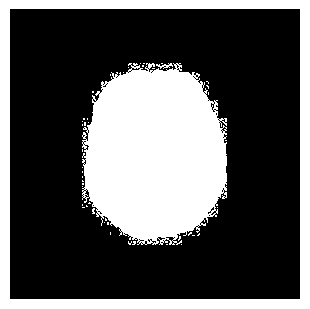

[2023-11-07 16:37:50] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [69]:
predicoes.show(show_confidence=True)

In [68]:
predicoes

ImagesDetectionPrediction(_images_prediction_lst=[ImageDetectionPrediction(image=array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32), predicti